# QITE - Evaluation

In [1]:
from typing import List, Tuple, Dict, Any, Optional, Union, Set
from multiprocessing import Pool
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path
from dataclasses import dataclass, field
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
PLATFORMS = [
    'qiskit', 'pennylane', 'pytket',
    # 'bqskit'
]
PATH_BUGS = "../reports/bugs_v001.csv"

In [3]:
EXPERIMENTS_MORPHQ = {
    "v14": {
        "path": "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v14",
        "description": "MorphQ Data - 1h - Qiskit"
    },
    "v16": {
        "path": "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v16",
        "description": "MorphQ Data - 30 sec - Qiskit - Thread"
    },
    "v21": {
        "path": "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v21",
        "description": "MorphQ Data - 30 sec - Qiskit - Thread"
    },
    "v22": {
        "path": "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v22",
        "description": "MorphQ Data - 5 min - Qiskit - Thread"
    },
    "v23": {
        "path": "/home/paltenmo/projects/morphq_upgraded/MorphQ-Quantum-Qiskit-Testing-ICSE-23/data/qmt_v23",
        "description": "MorphQ Data - 1h - Qiskit - Thread"
    }
}
# add provenance field to the data
EXPERIMENTS_MORPHQ = {
    k: {**v, "provenance": "morphq"} for k, v in EXPERIMENTS_MORPHQ.items()
}

EXPERIMENTS_QITE = {
    # "2025_03_07__16_41": {
    #     "path": "../program_bank/v045/2025_03_07__16_41",
    #     "description": "1h - 3 platforms  - threads + converters"
    # },
    # program_bank/v047/2025_03_08__18_21
    "2025_03_08__18_21": {
        "path": "../program_bank/v047/2025_03_08__18_21",
        "description": "1h - 3 platforms  - threads + converters"
    },
    # five runs of the same experiment
    # program_bank/v047/2025_03_08__23_10_1f8161
    "2025_03_08__23_10_1f8161": {
        "path": "../program_bank/v047/2025_03_08__23_10_1f8161",
        "description": "1h - 3 platforms  - threads + converters"
    },
    # program_bank/v047/2025_03_08__23_10_25ac21
    "2025_03_08__23_10_25ac21": {
        "path": "../program_bank/v047/2025_03_08__23_10_25ac21",
        "description": "1h - 3 platforms  - threads + converters"
    },
    # program_bank/v047/2025_03_08__23_10_49eaef
    "2025_03_08__23_10_49eaef": {
        "path": "../program_bank/v047/2025_03_08__23_10_49eaef",
        "description": "1h - 3 platforms  - threads + converters"
    },
    # program_bank/v047/2025_03_08__23_10_387c1b
    "2025_03_08__23_10_387c1b": {
        "path": "../program_bank/v047/2025_03_08__23_10_387c1b",
        "description": "1h - 3 platforms  - threads + converters"
    },
    # program_bank/v047/2025_03_08__23_10_c67442
    "2025_03_08__23_10_c67442": {
        "path": "../program_bank/v047/2025_03_08__23_10_c67442",
        "description": "1h - 3 platforms  - threads + converters"
    },
}
# add provenance field to the data
EXPERIMENTS_QITE = {
    k: {**v, "provenance": "qite"} for k, v in EXPERIMENTS_QITE.items()
}

EXPERIMENTS_COVERAGE = [
    "2025_03_08__23_10_1f8161",
    "2025_03_08__23_10_25ac21",
    "2025_03_08__23_10_49eaef",
    "2025_03_08__23_10_387c1b",
    "2025_03_08__23_10_c67442",
]


EXPERIMENTS_ALL = {
    **EXPERIMENTS_MORPHQ,
    **EXPERIMENTS_QITE
}
SELECTED_EXP_QITE = "2025_03_08__18_21"
SELECTED_EXP_MORPHQ = "v23"

## RQ: Bugs Found

In [4]:
import re


def transform_triggerable(value: str) -> str:
    """Convert yes/no string to LaTeX tick/cross mark."""
    return r"\ding{51}" if value.startswith("yes") else r"\ding{55}"


def format_code_blocks(text: str) -> str:
    """Replace backticked text with LaTeX code environment."""
    if not isinstance(text, str):
        return text
    return re.sub(r'`([^`]+)`', r'\\code{\1}', text)


def generate_latex_macro_name(text: str) -> str:
    """Generate a camel case LaTeX macro name from the input text."""
    text = text.replace("\code{", "").replace("}", "")  # Remove code blocks
    words = re.findall(r'\b\w+\b', text)  # Extract words
    words = [re.sub(r'\d+', '', word) for word in words]  # Remove digits
    words = [re.sub(r'[^\w\s]', '', word)
             for word in words]  # Remove punctuation
    # Lowercase and remove empty strings
    words = [word.lower() for word in words if word]

    selected_words = words[:5] if len(words) >= 4 else words[:3]
    camel_case = ''.join(word.capitalize() for word in words)
    # Use first 4-5 letters if available, otherwise 3
    return camel_case


def prepare_bugs_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Transform bugs data for LaTeX output."""
    # Drop unnecessary columns
    df = df.drop(columns=[
        'github_link',
        'crash_msg',
        'substr_crash_msg'
    ])
    # Apply transformations
    if not "triggerable" in df.columns:
        df = df.rename(columns={"is_still_triggerable": "triggerable"})
    df["triggerable"] = df["triggerable"].apply(transform_triggerable)
    df["short_desc"] = df["short_desc"].apply(format_code_blocks)

    # Generate LaTeX commands
    for i, row in df.iterrows():
        print(
            f"\\newcommand{{\\IdBug" +
            generate_latex_macro_name(row['short_desc']) + "}{" + str(i + 1) + "}")

    # Format column names
    df.columns = df.columns.str.replace("_", " ").str.title()
    # Adjust index to start from 1
    df.index += 1
    return df


df_bugs = pd.read_csv(PATH_BUGS)
df_bugs = prepare_bugs_dataframe(df_bugs)

# Print LaTeX table
print(df_bugs.to_latex(index=True))

\newcommand{\IdBugImplicitRegisterReorderingAlteringSemantics}{1}
\newcommand{\IdBugUnexpectedReallocationOfGatesToDifferentQubits}{2}
\newcommand{\IdBugMissingStandardRxxGateDefinition}{3}
\newcommand{\IdBugUnrecognizedDelayGate}{4}
\newcommand{\IdBugErrorConvertingDecomposedCircuitPhasedxOp}{5}
\newcommand{\IdBugMissingControlledPhaseCsGateDefinition}{6}
\newcommand{\IdBugErrorExportingQasmFileMidmeasurempOp}{7}
\newcommand{\IdBugUnitaryMatrixMismatchInCuGateImplementation}{8}
\newcommand{\IdBugIncompatOfPhasedxGateWithGreedypaulisimpOpt}{9}
\newcommand{\IdBugUnsupportedIswapGate}{10}
\newcommand{\IdBugZxgraphlikeoptPassCreateNotEquivalentCircuit}{11}
\newcommand{\IdBugFullpeepholeoptPassFailsWithMcrzGate}{12}
\newcommand{\IdBugIncorrectMcxGateGenerationCxInsteadOfCx}{13}
\newcommand{\IdBugIncorrectUGateConversionToU}{14}
\newcommand{\IdBugFullpeepholeoptPassFailsWithUAndCxGates}{15}
\newcommand{\IdBugExporterCrashWithUnusualRegisterName}{16}
\newcommand{\IdBugMisplacingConsecutiveOp

In [5]:
df_bugs

,Platform,Short Desc,Status,Oracle,Triggerable
1,TKET,Implicit register reordering altering semantics,Confirmed,Equivalence,\ding{55}
2,PennyLane,Unexpected reallocation of gates to different ...,Confirmed,Equivalence,\ding{55}
3,Qiskit,Missing standard \code{rxx} gate definition,Confirmed,Crash,\ding{55}
4,BQSKit,Unrecognized delay gate,Confirmed,Crash,\ding{51}
5,TKET,Error converting decomposed circuit (\code{Pha...,Confirmed,Crash,\ding{51}
6,BQSKit,Missing controlled phase \code{cs} gate defini...,Confirmed,Crash,\ding{51}
7,PennyLane,Error exporting QASM file: \code{MidMeasureMP} op,Confirmed,Crash,\ding{51}
8,PennyLane,Unitary matrix mismatch in \code{cu} gate impl...,Confirmed,Equivalence,\ding{51}
9,TKET,Incompat. of \code{PhasedX} gate with \code{Gr...,Confirmed,Equivalence,\ding{51}
10,TKET,Unsupported \code{ISwap} gate,Fixed,Crash,\ding{51}


### Compare Warnings Single Run

In [6]:
from multiprocessing import Pool
import re


def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["_filename"] = os.path.basename(file_path)
        return data


def read_all_jsons(dir_path: str) -> pd.DataFrame:
    json_files = [os.path.join(dir_path, f) for f in os.listdir(
        dir_path) if re.match(r'.*\.json$', f)]
    records = []

    with Pool() as pool:
        results = pool.map(read_json_file, json_files)
        records.extend(results)

    return pd.DataFrame(records)


df_errors = read_all_jsons(
    Path(EXPERIMENTS_ALL[SELECTED_EXP_QITE]["path"]) / "error")
df_errors["experiment"] = SELECTED_EXP_QITE
all_errors = df_errors["error"].tolist()
df_errors.head(30)

,error,traceback,timestamp,crashing_operation,input_qasm,platform,round,importer_function,transformer_functions,exporter_function,importer_time,transformation_time,exporter_time,_filename,experiment
0,Gate has an invalid number of parameters,"Traceback (most recent call last):\n File ""/h...",1.741455e+09,pytket_import,program_bank/v047/2025_03_08__18_21/0000508_78...,pytket,1,None,[],None,NaN,[],None,0000508_787bc3_79632d_error.json,2025_03_08__18_21
1,Operation QubitUnitary not supported by the QA...,"Traceback (most recent call last):\n File ""/h...",1.741455e+09,pennylane_export,program_bank/v047/2025_03_08__18_21/0000488_3b...,pennylane,1,pennylane_import,[pennylane_optimizer_commute_controlled],None,0.005320,[5.054473876953125e-05],None,0000488_3b6f47_588fbd_error.json,2025_03_08__18_21
2,Can only build replacement circuits for basic ...,"Traceback (most recent call last):\n File ""/h...",1.741455e+09,pytket_change_gateset_Rx_Ry_Rz_CZ,program_bank/v047/2025_03_08__18_21/0000315_17...,pytket,1,pytket_import,[pytket_change_gateset_Rx_Ry_Rz_CZ],None,0.098561,[],None,0000315_17b4c9_a981b5_error.json,2025_03_08__18_21
3,Operation QubitUnitary not supported by the QA...,"Traceback (most recent call last):\n File ""/h...",1.741455e+09,pennylane_export,program_bank/v047/2025_03_08__18_21/0000298_e9...,pennylane,1,pennylane_import,[pennylane_optimizer_cancel_inverses],None,0.005037,[7.2479248046875e-05],None,0000298_e940a1_e7386d_error.json,2025_03_08__18_21
4,Operation QubitUnitary not supported by the QA...,"Traceback (most recent call last):\n File ""/h...",1.741455e+09,pennylane_export,program_bank/v047/2025_03_08__18_21/0000486_7d...,pennylane,1,pennylane_import,[pennylane_optimizer_undo_swaps],None,0.023487,[0.00014448165893554688],None,0000486_7d80f8_b036a5_error.json,2025_03_08__18_21
5,Can only build replacement circuits for basic ...,"Traceback (most recent call last):\n File ""/h...",1.741455e+09,pytket_change_gateset_U1_U2_U3_CX,program_bank/v047/2025_03_08__18_21/0000589_33...,pytket,1,pytket_import,[pytket_change_gateset_U1_U2_U3_CX],None,0.060703,[],None,0000589_33c583_1d0233_error.json,2025_03_08__18_21
6,"""0000096_qite_9a5dd2.qasm:64,0: 'c4x' takes 5 ...","Traceback (most recent call last):\n File ""/h...",1.741456e+09,qiskit_import,program_bank/v047/2025_03_08__18_21/0000096_qi...,qiskit,3,None,[],None,NaN,[],None,0000096_qite_9a5dd2_679c15_error.json,2025_03_08__18_21
7,Gate has an invalid number of parameters,"Traceback (most recent call last):\n File ""/h...",1.741455e+09,pytket_import,program_bank/v047/2025_03_08__18_21/0000704_1b...,pytket,1,None,[],None,NaN,[],None,0000704_1b5a5a_3b828e_error.json,2025_03_08__18_21
8,Can only build replacement circuits for basic ...,"Traceback (most recent call last):\n File ""/h...",1.741455e+09,pytket_change_gateset_U1_U2_U3_CX,program_bank/v047/2025_03_08__18_21/0000437_d0...,pytket,1,pytket_import,[pytket_change_gateset_U1_U2_U3_CX],None,0.074679,[],None,0000437_d06cd0_bfbe8c_error.json,2025_03_08__18_21
9,Can only build replacement circuits for basic ...,"Traceback (most recent call last):\n File ""/h...",1.741455e+09,pytket_change_gateset_Rz_SX_X_CX,program_bank/v047/2025_03_08__18_21/0000807_76...,pytket,1,pytket_import,[pytket_change_gateset_Rz_SX_X_CX],None,0.090865,[],None,0000807_763fdf_791eca_error.json,2025_03_08__18_21


In [7]:
df_bugs = pd.read_csv(PATH_BUGS)
# check for value in the df_bugs "substr_crash_msg" column if that value is
# present in any of the latest all_errors, create a new column
df_bugs["triggered_in_latest"] = df_bugs["substr_crash_msg"].apply(
    lambda x: "yes" if any([x in error for error in set(all_errors)]) else "no"
)
df_bugs

,github_link,platform,short_desc,status,oracle,crash_msg,substr_crash_msg,is_still_triggerable,triggered_in_latest
0,https://github.com/CQCL/tket/issues/1652,TKET,Implicit register reordering altering semantics,Confirmed,Equivalence,NaN,not equivalent,no_because_of_generator,no
1,https://github.com/PennyLaneAI/pennylane/issue...,PennyLane,Unexpected reallocation of gates to different ...,Confirmed,Equivalence,NaN,not equivalent,no_because_of_workaround,no
2,https://github.com/Qiskit/qiskit/issues/12124,Qiskit,Missing standard `rxx` gate definition,Confirmed,Crash,"QASM2ParseError : ""< input >:3 ,27: 'rxx ' is ...",rxx ' is not defined in this scope,no_because_of_workaround,no
3,https://github.com/BQSKit/bqskit/issues/307,BQSKit,Unrecognized delay gate,Confirmed,Crash,LangException: Unrecognized gate: delay.,Unrecognized gate: delay,yes_if_enabling_gate,no
4,https://github.com/CQCL/tket/issues/1629,TKET,Error converting decomposed circuit (`PhasedX`...,Confirmed,Crash,Cannot print command of type: PhasedX(0.536226...,Cannot print command of type: PhasedX,yes_in_principle,no
5,https://github.com/BQSKit/bqskit/issues/306,BQSKit,Missing controlled phase `cs` gate definition,Confirmed,Crash,cs' is not defined in this scope,cs' is not defined in this scope,yes_in_principle,no
6,https://github.com/PennyLaneAI/pennylane/issue...,PennyLane,Error exporting QASM file: `MidMeasureMP` op,Confirmed,Crash,Operation MidMeasureMP not supported by the QA...,Operation MidMeasureMP not supported by the QA...,yes_in_principle,no
7,https://github.com/PennyLaneAI/pennylane/issue...,PennyLane,Unitary matrix mismatch in `cu` gate implement...,Confirmed,Equivalence,NaN,not equivalent,yes_in_principle,no
8,https://github.com/CQCL/tket/issues/1771,TKET,Incompat. of `PhasedX` gate with `GreedyPauliS...,Confirmed,Equivalence,NaN,not equivalent,yes_in_principle,no
9,https://github.com/CQCL/tket/issues/1605,TKET,Unsupported `ISwap` gate,Fixed,Crash,Gate has an invalid number of parameters,invalid number of parameters,yes_if_enabling_gate,yes


## RQ: Comparison with Prior Work

In [8]:
# todo add coverage data to a dictionary to use later easily for the venn
COVERAGE_DATA_ALL = {}

for exp_name, exp_info in EXPERIMENTS_ALL.items():
    print(
        f"Experiment: {exp_name} - ({exp_info['description']}) - {exp_info['provenance']}")
    if "coverage_xml" in os.listdir(exp_info["path"]):
        # new experiments with coverage each round
        latest_coverage_folder = Path(exp_info["path"]) / "coverage_xml"
        # Get all subdirectories that are numeric and zerothed
        coverage_dirs = sorted([
            d.name for d in latest_coverage_folder.iterdir()
            if d.is_dir() and d.name.isdigit()])
        if coverage_dirs:
            exp_coverage_folder = latest_coverage_folder / coverage_dirs[-1]
            print(f"Coverage data found in {exp_coverage_folder}")
        else:
            raise Exception("No coverage data found")
    else:
        # morphq or old qite experiments
        exp_coverage_folder = exp_info["path"]
    exp_coverage_data_path = Path(
        exp_coverage_folder) / "coverage_platforms.json"
    with open(exp_coverage_data_path, "r") as f:
        exp_coverage_data = json.load(f)
    COVERAGE_DATA_ALL[exp_name] = exp_coverage_data
    for package, coverage in exp_coverage_data.items():
        print(
            f"{package:_<15}: {coverage['coverage_percentage']:.2f}% ({coverage['covered']}/{coverage['total']})")

Experiment: v14 - (MorphQ Data - 1h - Qiskit) - morphq
qiskit_________: 9.49% (6904/72751)
pennylane______: 0.00% (0/0)
pytket_________: 0.00% (0/0)
Experiment: v16 - (MorphQ Data - 30 sec - Qiskit - Thread) - morphq
qiskit_________: 14.33% (10425/72751)
pennylane______: 0.00% (0/0)
pytket_________: 0.00% (0/0)
Experiment: v21 - (MorphQ Data - 30 sec - Qiskit - Thread) - morphq
qiskit_________: 12.41% (9027/72751)
pennylane______: 0.00% (0/0)
pytket_________: 0.00% (0/0)
Experiment: v22 - (MorphQ Data - 5 min - Qiskit - Thread) - morphq
qiskit_________: 14.49% (10538/72751)
pennylane______: 0.00% (0/0)
pytket_________: 0.00% (0/0)
Experiment: v23 - (MorphQ Data - 1h - Qiskit - Thread) - morphq
qiskit_________: 14.69% (10689/72751)
pennylane______: 0.00% (0/0)
pytket_________: 0.00% (0/0)
Experiment: 2025_03_08__18_21 - (1h - 3 platforms  - threads + converters) - qite
Coverage data found in ../program_bank/v047/2025_03_08__18_21/coverage_xml/0006
qiskit_________: 12.50% (9097/72751)
pe


Experiment: 2025_03_08__18_21
MorphQ experiment: v23
Description: 1h - 3 platforms  - threads + converters


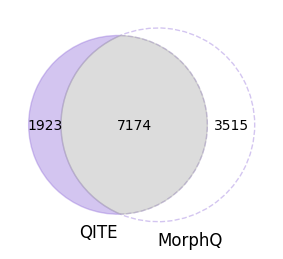

\newcommand{\QITEQiskitCoverage}{12.50\%}
\newcommand{\MorphQQiskitCoverage}{14.69\%}
\newcommand{\QITEQiskitTotalLines}{72,751}
\newcommand{\MorphQQiskitTotalLines}{72,751}
\newcommand{\QITEQiskitCoveredLines}{9,097}
\newcommand{\MorphQQiskitCoveredLines}{10,689}
\newcommand{\CoveredSharedLines}{7,174}
\newcommand{\CoveredOnlyQITE}{1,923}
\newcommand{\CoveredOnlyMorphQ}{3,515}


In [9]:
from matplotlib_venn import venn2

# Styling constants
FIGURE_SIZE = (6, 3)
# light purple, light gray, white
STYLE_COLORS = ['mediumpurple', 'darkgray', 'white']
OUTPUT_IMAGE_PATH = "images/rq_coverage_venn_vs_morphq.pdf"


@dataclass
class VennDiagramData:
    """Data structure for Venn diagram components."""
    exclusive_set1: Set[str]
    exclusive_set2: Set[str]
    intersection: Set[str]


def calculate_venn_sets(set1: Set[str], set2: Set[str]) -> VennDiagramData:
    """Calculate exclusive and intersection sets for Venn diagram."""
    return VennDiagramData(
        exclusive_set1=set1 - set2,
        exclusive_set2=set2 - set1,
        intersection=set1 & set2,
    )


def style_venn_diagram(venn: Any, data: VennDiagramData) -> None:
    """Apply styling to Venn diagram components."""
    # Set size labels
    for id, size in [
        ('10', len(data.exclusive_set1)),
        ('01', len(data.exclusive_set2)),
        ('11', len(data.intersection))
    ]:
        venn.get_label_by_id(id).set_text(size)

    # Style sections
    venn.get_patch_by_id('10').set_color(STYLE_COLORS[0])
    patch01 = venn.get_patch_by_id('01')
    patch01.set_edgecolor(STYLE_COLORS[0])
    patch01.set_linestyle('dashed')
    patch01.set_facecolor('white')
    venn.get_patch_by_id('11').set_color(STYLE_COLORS[1])


def create_coverage_venn_diagram(
    qite_lines: Set[str],
    morphq_lines: Set[str],
    qite_label: str = 'QITE',
    morphq_label: str = 'MorphQ',
) -> Tuple[plt.Figure, plt.Axes, VennDiagramData]:
    """Create and style Venn diagram comparing covered lines."""
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)
    venn_data = calculate_venn_sets(qite_lines, morphq_lines)

    venn = venn2(
        subsets=[qite_lines, morphq_lines],
        set_labels=(qite_label, morphq_label),
        ax=ax,
    )
    style_venn_diagram(venn, venn_data)

    plt.show()
    fig.savefig(OUTPUT_IMAGE_PATH)
    return fig, ax, venn_data


def print_latex_commands(
    cov_qiskit_ours: dict,
    cov_qiskit_morphq: dict,
    venn_data: VennDiagramData,
) -> None:
    """
    Print LaTeX commands for coverage statistics.

    Args:
        cov_qiskit_ours: Coverage data from QITE approach
        cov_qiskit_morphq: Coverage data from MorphQ approach
        venn_data: VennDiagramData containing set intersection info
    """
    coverage_commands = [
        ("QITEQiskitCoverage",
            f"{cov_qiskit_ours['coverage_percentage']:.2f}\\%"),
        ("MorphQQiskitCoverage",
            f"{cov_qiskit_morphq['coverage_percentage']:.2f}\\%"),
        ("QITEQiskitTotalLines",
            f"{cov_qiskit_ours['total']:,.0f}"),
        ("MorphQQiskitTotalLines",
            f"{cov_qiskit_morphq['total']:,.0f}"),
        ("QITEQiskitCoveredLines",
            f"{cov_qiskit_ours['covered']:,.0f}"),
        ("MorphQQiskitCoveredLines",
            f"{cov_qiskit_morphq['covered']:,.0f}"),
        ("CoveredSharedLines", f"{len(venn_data.intersection):,.0f}"),
        ("CoveredOnlyQITE", f"{len(venn_data.exclusive_set1):,.0f}"),
        ("CoveredOnlyMorphQ", f"{len(venn_data.exclusive_set2):,.0f}"),
    ]

    for cmd_name, value in coverage_commands:
        print(f"\\newcommand{{\\{cmd_name}}}{{{value}}}")


cov_morphq = COVERAGE_DATA_ALL[SELECTED_EXP_MORPHQ]

for exp_name in [SELECTED_EXP_QITE]:
    print(f"\nExperiment: {exp_name}")
    print(f"MorphQ experiment: {SELECTED_EXP_MORPHQ}")
    print(f"Description: {EXPERIMENTS_ALL[exp_name]['description']}")
    cov_qite = COVERAGE_DATA_ALL[exp_name]
    # Example usage remains the same but with named arguments
    fig, ax, venn_data = create_coverage_venn_diagram(
        qite_lines=set(cov_qite["qiskit"]["covered_lines"]),
        morphq_lines=set(cov_morphq["qiskit"]["covered_lines"]),
    )
    print_latex_commands(
        cov_qiskit_ours=cov_qite["qiskit"],
        cov_qiskit_morphq=cov_morphq["qiskit"],
        venn_data=venn_data,
    )

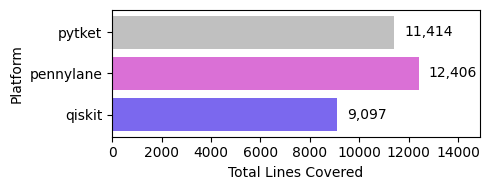

\newcommand{\QITEQiskitTotalLines}{72,751}
\newcommand{\QITEQiskitCoveredLines}{9,097}
\newcommand{\QITEPennylaneTotalLines}{47,509}
\newcommand{\QITEPennylaneCoveredLines}{12,406}
\newcommand{\QITEPytketTotalLines}{38,415}
\newcommand{\QITEPytketCoveredLines}{11,414}


In [10]:
PLATFORM_COLORS = {'qiskit': 'mediumslateblue',
                   'pytket': 'silver', 'pennylane': 'orchid'}
OUTPUT_DIR = "images"
OUTPUT_PATH_BAR_PLOT = os.path.join(OUTPUT_DIR, "rq_coverage_barplot.pdf")


def create_platform_bar_plot(package_coverage, platforms, output_path):
    """Generates and saves a horizontal bar plot of platform coverage."""
    platform_colors = [PLATFORM_COLORS[platform] for platform in platforms]
    total_lines_covered = [package_coverage[platform]['covered']
                           for platform in platforms]

    fig, ax = plt.subplots(figsize=(5, 2))
    bars = ax.barh(platforms, total_lines_covered, color=platform_colors)
    ax.set_xlabel('Total Lines Covered')
    ax.set_ylabel('Platform')

    max_val = max(total_lines_covered)
    add_bar_value_labels(ax, bars, total_lines_covered, max_val)

    ax.set_xlim(0, max_val * 1.2)
    fig.tight_layout()
    plt.show()
    fig.savefig(output_path)


def add_bar_value_labels(ax, bars, values, max_val):
    """Adds labels to the end of each bar in a horizontal bar plot."""
    for bar, value in zip(bars, values):
        ax.text(value + (max_val / 30), bar.get_y() + bar.get_height() / 2,
                f'{value:,.0f}', va='center', ha='left')


def print_latex_commands(package_coverage, platforms):
    """Prints LaTeX commands for total and covered lines for each platform."""
    for platform in platforms:
        total_lines = package_coverage[platform]['total']
        covered_lines = package_coverage[platform]['covered']
        print(
            f"\\newcommand{{\\QITE{platform.capitalize()}TotalLines}}{{{total_lines:,.0f}}}")
        print(
            f"\\newcommand{{\\QITE{platform.capitalize()}CoveredLines}}{{{covered_lines:,.0f}}}")


# Main execution
create_platform_bar_plot(
    package_coverage=COVERAGE_DATA_ALL[SELECTED_EXP_QITE],
    platforms=PLATFORMS,
    output_path=OUTPUT_PATH_BAR_PLOT,
)
print_latex_commands(
    package_coverage=COVERAGE_DATA_ALL[SELECTED_EXP_QITE],
    platforms=PLATFORMS)

### Compare Warnings

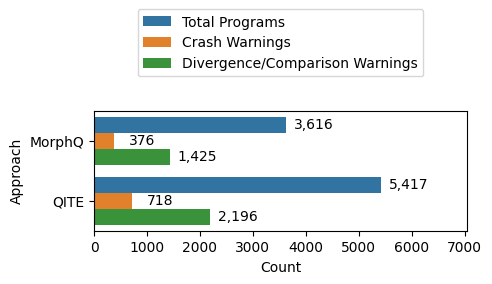

\newcommand{\TotalMorphQPrograms}{3,616}
\newcommand{\TotalOursPrograms}{5,417}
\newcommand{\RatioNewProgramsBestThenMorphQ}{1.50}
\newcommand{\TotalMorphQCrashes}{376}
\newcommand{\TotalOursCrashes}{718}
\newcommand{\RatioNewCrashesBestThenMorphQ}{1.91}
\newcommand{\TotalMorphQDivergences}{1,425}
\newcommand{\TotalOursDivergences}{2,196}
\newcommand{\RatioNewDivergencesBestThenMorphQ}{1.54}


In [11]:
import sqlite3 as sl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Any

# Global variables for MorphQ
PATH_PROGRAMS_MORPHQ = Path(
    EXPERIMENTS_MORPHQ[SELECTED_EXP_MORPHQ]["path"]) / "programs/source"
PATH_WARNINGS_MORPHQ = Path(
    EXPERIMENTS_MORPHQ[SELECTED_EXP_MORPHQ]["path"]) / "qfl.db"

# Global variables for QITE
ERROR_FOLDER_QITE = Path(EXPERIMENTS_QITE[SELECTED_EXP_QITE]["path"]) / "error"
PROGRAM_FOLDER_QITE = Path(EXPERIMENTS_QITE[SELECTED_EXP_QITE]["path"])
COMPARISON_FOLDER_QITE = Path(
    EXPERIMENTS_QITE[SELECTED_EXP_QITE]["path"]) / "comparison"


def get_morphq_stats() -> Dict[str, int]:
    """Get program, crash and divergence counts for MorphQ"""
    conn = sl.connect(PATH_WARNINGS_MORPHQ)
    crashes_df = pd.read_sql("SELECT * from CRASHDATA", conn)
    executions_df = pd.read_sql("SELECT * from QFLDATA", conn)

    return {
        'programs': len([f for f in os.listdir(PATH_PROGRAMS_MORPHQ) if f.endswith('.py')]) * 2,
        'crashes': len(crashes_df),
        'divergences': len(executions_df)
    }


def get_qite_stats() -> Dict[str, int]:
    """Get program, crash and divergence counts for QITE"""
    return {
        'programs': len([f for f in os.listdir(PROGRAM_FOLDER_QITE) if f.endswith('.qasm')]),
        'crashes': len([f for f in os.listdir(ERROR_FOLDER_QITE) if f.endswith('.json')]),
        'divergences': len([f for f in os.listdir(COMPARISON_FOLDER_QITE) if f.endswith('.json')])
    }


def create_comparison_plot(
        morphq_stats: Dict[str, int],
        qite_stats: Dict[str, int]) -> None:
    """Create and save comparison barplot between MorphQ and QITE"""
    df_combined = pd.DataFrame({
        'Category': ['Total Programs', 'Crash Warnings', 'Divergence/Comparison Warnings'] * 2,
        'Approach': ['MorphQ'] * 3 + ['QITE'] * 3,
        'Count': [
            morphq_stats['programs'], morphq_stats['crashes'], morphq_stats['divergences'],
            qite_stats['programs'], qite_stats['crashes'], qite_stats['divergences']
        ]
    })

    fig, ax = plt.subplots(figsize=(5, 6))
    bar_plot = sns.barplot(y='Approach', x='Count',
                           hue='Category', data=df_combined, ax=ax)

    for p in bar_plot.patches:
        if p.get_width() != 0:
            bar_plot.annotate(
                format(p.get_width(), ',.0f'),
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='center', va='center', xytext=(20, 0), textcoords='offset points'
            )

    ax.set_ylabel('Approach')
    ax.set_xlim(0, max(df_combined['Count']) * 1.3)
    ax.set_xlabel('Count')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.9), ncol=1)

    plt.tight_layout(pad=1)
    plt.show()
    fig.savefig("images/rq_warnings.pdf", bbox_inches='tight')


def print_latex_stats_commands(
        morphq_stats: Dict[str, int],
        qite_stats: Dict[str, int]) -> None:
    """Print LaTeX commands for statistics comparison."""
    # Programs
    print("\\newcommand{\\TotalMorphQPrograms}{" +
          f"{morphq_stats['programs']:,.0f}" + "}")
    print("\\newcommand{\\TotalOursPrograms}{" +
          f"{qite_stats['programs']:,.0f}" + "}")
    ratio_programs = qite_stats['programs'] / morphq_stats['programs']
    print(
        "\\newcommand{\\RatioNewProgramsBestThenMorphQ}{" +
        f"{ratio_programs:.2f}" + "}")

    # Crashes
    print("\\newcommand{\\TotalMorphQCrashes}{" +
          f"{morphq_stats['crashes']:,.0f}" + "}")
    print(
        "\\newcommand{\\TotalOursCrashes}{" + f"{qite_stats['crashes']:,.0f}" + "}")
    ratio_crashes = qite_stats['crashes'] / morphq_stats['crashes']
    print(
        "\\newcommand{\\RatioNewCrashesBestThenMorphQ}{" +
        f"{ratio_crashes:.2f}" + "}")

    # Divergences
    print("\\newcommand{\\TotalMorphQDivergences}{" +
          f"{morphq_stats['divergences']:,.0f}" + "}")
    print("\\newcommand{\\TotalOursDivergences}{" +
          f"{qite_stats['divergences']:,.0f}" + "}")
    ratio_divergences = qite_stats['divergences'] / \
        morphq_stats['divergences'] if morphq_stats['divergences'] > 0 else 0
    print(
        "\\newcommand{\\RatioNewDivergencesBestThenMorphQ}{" +
        f"{ratio_divergences:.2f}" + "}")


# Main execution
morphq_stats = get_morphq_stats()
qite_stats = get_qite_stats()
create_comparison_plot(morphq_stats, qite_stats)
print_latex_stats_commands(morphq_stats, qite_stats)

QITE experiment: 2025_03_08__18_21
MorphQ experiment: v23
Total files with exclusive QITE coverage: 45
Total lines covered only by QITE: 1923

Breakdown by file:

circuit/bit.py: 1 lines
circuit/controlledgate.py: 2 lines
circuit/instruction.py: 13 lines
circuit/library/data_preparation/initializer.py: 3 lines
circuit/library/data_preparation/state_preparation.py: 21 lines
circuit/library/generalized_gates/rv.py: 12 lines
circuit/library/generalized_gates/unitary.py: 7 lines
circuit/library/standard_gates/dcx.py: 1 lines
circuit/library/standard_gates/iswap.py: 1 lines
circuit/library/standard_gates/multi_control_rotation_gates.py: 111 lines
circuit/library/standard_gates/p.py: 19 lines
circuit/library/standard_gates/r.py: 20 lines
circuit/library/standard_gates/ryy.py: 14 lines
circuit/library/standard_gates/rz.py: 4 lines
circuit/library/standard_gates/rzx.py: 20 lines
circuit/library/standard_gates/s.py: 2 lines
circuit/library/standard_gates/u.py: 2 lines
circuit/library/standard_g

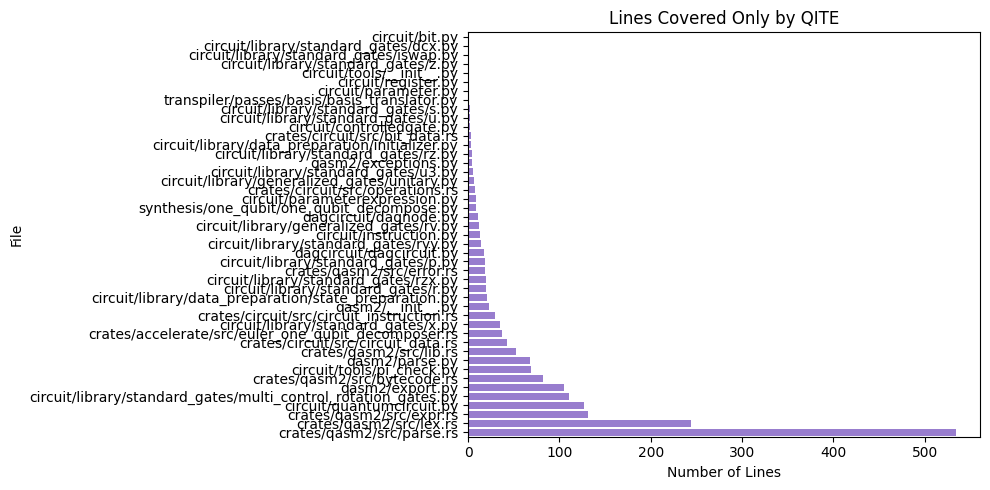

Total files with exclusive MorphQ coverage: 129
Total lines covered only by MorphQ: 3515

Breakdown by file:

circuit/add_control.py: 5 lines
circuit/bit.py: 3 lines
circuit/classicalregister.py: 2 lines
circuit/commutation_checker.py: 112 lines
circuit/controlledgate.py: 3 lines
circuit/instruction.py: 13 lines
circuit/library/generalized_gates/unitary.py: 3 lines
circuit/library/standard_gates/h.py: 1 lines
circuit/library/standard_gates/i.py: 1 lines
circuit/library/standard_gates/p.py: 11 lines
circuit/library/standard_gates/rx.py: 10 lines
circuit/library/standard_gates/rxx.py: 1 lines
circuit/library/standard_gates/ry.py: 2 lines
circuit/library/standard_gates/ryy.py: 1 lines
circuit/library/standard_gates/rz.py: 11 lines
circuit/library/standard_gates/rzx.py: 1 lines
circuit/library/standard_gates/rzz.py: 1 lines
circuit/library/standard_gates/s.py: 2 lines
circuit/library/standard_gates/swap.py: 1 lines
circuit/library/standard_gates/sx.py: 2 lines
circuit/library/standard_gate

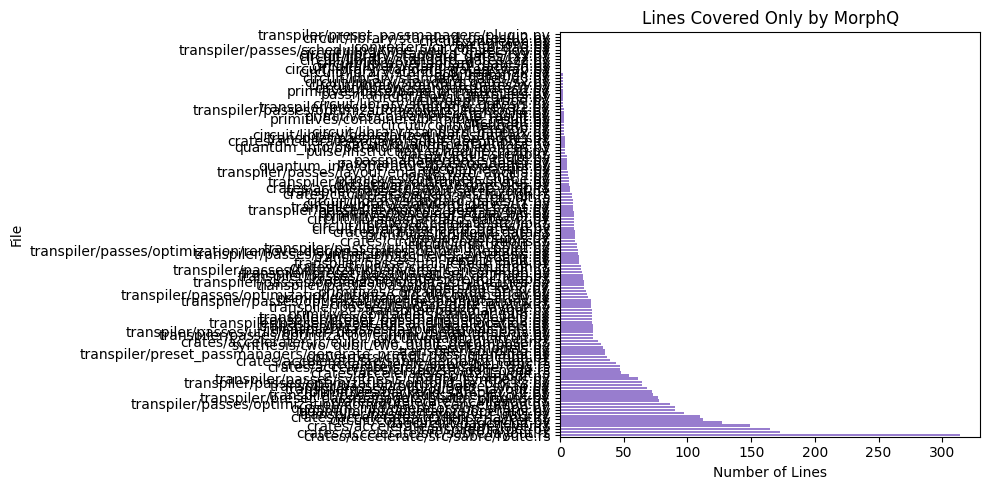

In [ ]:
def compare_line_coverage(include_lines: Set[str], exclude_lines: Set[str],
                          include_label: str, exclude_label: str,
                          file_patterns: List[str] = ["rs", "py"]) -> None:
    """
    Analyze and print code lines that are covered by one approach but not another.

    Args:
        include_lines: Set of lines to analyze for exclusive coverage
        exclude_lines: Set of lines to exclude
        include_label: Label for the include set (e.g. "QITE")
        exclude_label: Label for the exclude set (e.g. "MorphQ")
        file_patterns: List of file extensions to filter (default: ["rs", "py"])
    """
    # Filter for matching files and get exclusive coverage
    exclusive_lines = {
        line for line in (include_lines - exclude_lines)
        if any(f".{pattern}:" in line for pattern in file_patterns)
    }

    # Group by file
    file_groups = {}
    for line in sorted(exclusive_lines):
        file_path, line_number = line.split(':')
        if file_path not in file_groups:
            file_groups[file_path] = []
        file_groups[file_path].append(int(line_number))

    # Print summary and details
    print(
        f"Total files with exclusive {include_label} coverage: {len(file_groups)}")
    print(
        f"Total lines covered only by {include_label}: {len(exclusive_lines)}")
    print("\nBreakdown by file:")

    # Create data for plotting
    plot_data = []
    for file_path, lines in file_groups.items():
        print(f"\n{file_path}: {len(lines)} lines", end="")
        plot_data.append({
            'file': file_path,
            'lines': len(lines)
        })

    # Print LaTeX command for total number of exclusive lines
    print(
        f"\n\\newcommand{{\\LinesOnly{include_label}}}{{{len(exclusive_lines)}}}")

    # Create bar plot
    plt.figure(figsize=(10, 5))
    df_plot = pd.DataFrame(plot_data)
    df_plot = df_plot.sort_values('lines', ascending=True)

    sns.barplot(data=df_plot, y='file', x='lines', color='mediumpurple')
    plt.title(f'Lines Covered Only by {include_label}')
    plt.xlabel('Number of Lines')
    plt.ylabel('File')

    plt.tight_layout()
    plt.savefig(
        f'images/coverage_comparison_{include_label}_{exclude_label}.pdf')
    plt.show()


# Get coverage data for the selected experiments
print("QITE experiment:", SELECTED_EXP_QITE)
qite_coverage = COVERAGE_DATA_ALL[SELECTED_EXP_QITE]["qiskit"]
print("MorphQ experiment:", SELECTED_EXP_MORPHQ)
morphq_coverage = COVERAGE_DATA_ALL[SELECTED_EXP_MORPHQ]["qiskit"]

# Analyze Rust lines
# analyze_rust_lines(
#     qite_lines=set(qite_coverage["covered_lines"]),
#     morphq_lines=set(morphq_coverage["covered_lines"])
# )

compare_line_coverage(
    include_lines=set(qite_coverage["covered_lines"]),
    exclude_lines=set(morphq_coverage["covered_lines"]),
    include_label="QITE",
    exclude_label="MorphQ",
    file_patterns=["rs", "py"]
)

# the opposite
compare_line_coverage(
    include_lines=set(morphq_coverage["covered_lines"]),
    exclude_lines=set(qite_coverage["covered_lines"]),
    include_label="MorphQ",
    exclude_label="QITE",
    file_patterns=["rs", "py"]
)

MorphQ experiment: v23
Total Rust files covered by MorphQ: 49
Total Rust lines covered by MorphQ: 4682

Breakdown by file:

crates/accelerate/src/convert_2q_block_matrix.rs: 88 lines
crates/accelerate/src/dense_layout.rs: 113 lines
crates/accelerate/src/edge_collections.rs: 1 lines
crates/accelerate/src/error_map.rs: 22 lines
crates/accelerate/src/euler_one_qubit_decomposer.rs: 705 lines
crates/accelerate/src/isometry.rs: 14 lines
crates/accelerate/src/lib.rs: 11 lines
crates/accelerate/src/nlayout.rs: 82 lines
crates/accelerate/src/optimize_1q_gates.rs: 3 lines
crates/accelerate/src/pauli_exp_val.rs: 6 lines
crates/accelerate/src/results/mod.rs: 13 lines
crates/accelerate/src/sabre/heuristic.rs: 49 lines
crates/accelerate/src/sabre/layer.rs: 149 lines
crates/accelerate/src/sabre/layout.rs: 173 lines
crates/accelerate/src/sabre/mod.rs: 18 lines
crates/accelerate/src/sabre/neighbor_table.rs: 40 lines
crates/accelerate/src/sabre/route.rs: 314 lines
crates/accelerate/src/sabre/sabre_dag.r

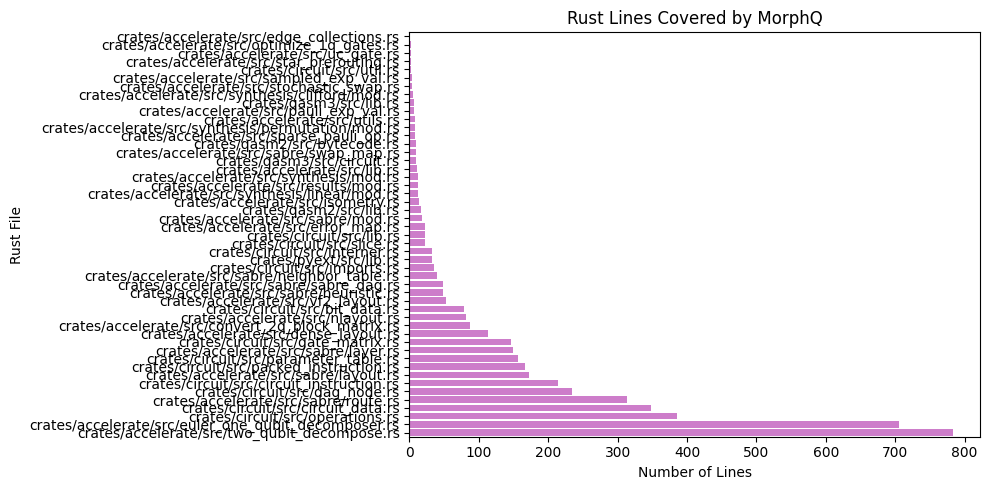


\newcommand{\RustLinesMorphQ}{4682}


In [ ]:
def analyze_file_coverage(
        lines: Set[str],
        label: str, file_patterns: List[str] = ["rs"]) -> None:
    """
    Analyze and print code lines covered by a specific approach.

    Args:
        lines: Set of lines to analyze
        label: Name of the approach (e.g. "MorphQ", "QITE")
        file_patterns: List of file extensions to filter (default: ["rs"])
    """
    # Filter for matching files
    filtered_lines = {
        line for line in lines
        if any(f".{pattern}:" in line for pattern in file_patterns)
    }

    # Group by file
    file_groups = {}
    for line in sorted(filtered_lines):
        file_path, line_number = line.split(':')
        if file_path not in file_groups:
            file_groups[file_path] = []
        file_groups[file_path].append(int(line_number))

    # Print summary and details
    print(f"Total files covered by {label}: {len(file_groups)}")
    print(f"Total lines covered by {label}: {len(filtered_lines)}")
    print("\nBreakdown by file:")

    # Create data for plotting
    plot_data = []
    for file_path, lines in file_groups.items():
        print(f"\n{file_path}: {len(lines)} lines", end="")
        plot_data.append({
            'file': file_path,
            'lines': len(lines)
        })
    # Print LaTeX command for total number of lines
    print(f"\n\\newcommand{{\\Lines{label}}}{{{len(filtered_lines)}}}")

    # Create bar plot
    plt.figure(figsize=(10, 5))
    df_plot = pd.DataFrame(plot_data)
    df_plot = df_plot.sort_values('lines', ascending=True)

    sns.barplot(data=df_plot, y='file', x='lines', color='orchid')
    plt.title(f'File Lines Covered by {label}')
    plt.xlabel('Number of Lines')
    plt.ylabel('File')

    plt.tight_layout()
    plt.savefig(f'images/file_coverage_{label.lower()}.pdf')
    plt.show()


# Get coverage data for MorphQ
print("MorphQ experiment:", SELECTED_EXP_MORPHQ)
morphq_coverage = COVERAGE_DATA_ALL[SELECTED_EXP_MORPHQ]["qiskit"]

# Analyze Rust lines for MorphQ
analyze_morphq_rust_lines(set(morphq_coverage["covered_lines"]))

## RQ: Program Diversity

In [24]:
def read_metadata_file(file_path: str) -> Dict[str, Any]:
    """Load metadata from JSON file and add filepath information."""
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        data['filepath'] = os.path.basename(file_path)
        data['fileprefix'] = Path(file_path).stem
        return data
    except Exception as e:
        print(f"Error reading metadata file: {file_path}")
        return None


def read_metadata_files(base_path: str) -> pd.DataFrame:
    """Create DataFrame from all metadata files in directory."""
    metadata_files = glob.glob(
        os.path.join(base_path, "metadata", "*.json"))
    with Pool() as pool:
        data = pool.map(read_metadata_file, metadata_files)
    # count None values (snedure less than 5) and then remove them
    print(f"Removing {data.count(None)} invalid metadata files")
    assert data.count(None) < 5
    data = [d for d in data if d is
            not None]  # remove None values from the list
    return pd.DataFrame(data)


dfs = []
for exp_name in EXPERIMENTS_COVERAGE:
    print(f"Experiment: {exp_name}")
    df = read_metadata_files(EXPERIMENTS_ALL[exp_name]["path"])
    print(f"Number of programs: {len(df)}")
    print(f"Columns: {df.columns}")
    dfs.append(df)

df_programs = pd.concat(dfs)

# Extract QASM data and content
df_programs['qasm_content'] = df_programs['output_qasm'].apply(
    lambda x: Path(os.path.join("..", x)).read_text()
)

df_programs.head()

Experiment: 2025_03_08__23_10_1f8161


Removing 0 invalid metadata files
Number of programs: 3900
Columns: Index(['input_qasm', 'platform', 'round', 'importer_function',
       'transformer_functions', 'exporter_function', 'importer_time',
       'transformation_time', 'exporter_time', 'output_qasm', 'filepath',
       'fileprefix'],
      dtype='object')
Experiment: 2025_03_08__23_10_25ac21
Removing 0 invalid metadata files
Number of programs: 3834
Columns: Index(['input_qasm', 'platform', 'round', 'importer_function',
       'transformer_functions', 'exporter_function', 'importer_time',
       'transformation_time', 'exporter_time', 'output_qasm', 'filepath',
       'fileprefix'],
      dtype='object')
Experiment: 2025_03_08__23_10_49eaef
Removing 0 invalid metadata files
Number of programs: 3946
Columns: Index(['input_qasm', 'platform', 'round', 'importer_function',
       'transformer_functions', 'exporter_function', 'importer_time',
       'transformation_time', 'exporter_time', 'output_qasm', 'filepath',
       'filep

,input_qasm,platform,round,importer_function,transformer_functions,exporter_function,importer_time,transformation_time,exporter_time,output_qasm,filepath,fileprefix,qasm_content
0,program_bank/v047/2025_03_08__23_10_1f8161/000...,pytket,2,pytket_import,[pytket_optimizer_flatten_registers],pytket_export,0.022215,[0.0015857219696044922],0.022667,program_bank/v047/2025_03_08__23_10_1f8161/000...,0000261_qite_cae0b5.json,0000261_qite_cae0b5,"OPENQASM 2.0;\ninclude ""qelib1.inc"";\n\nqreg q..."
1,program_bank/v047/2025_03_08__23_10_1f8161/000...,pytket,5,pytket_import,[pytket_optimizer_peephole_2q],pytket_export,0.102922,[5.3025195598602295],0.118185,program_bank/v047/2025_03_08__23_10_1f8161/000...,0000551_qite_c7c7b1.json,0000551_qite_c7c7b1,"OPENQASM 2.0;\ninclude ""qelib1.inc"";\n\nqreg q..."
2,program_bank/v047/2025_03_08__23_10_1f8161/000...,pennylane,5,pennylane_import,[pennylane_optimizer_unitary_to_rot],pennylane_export,0.015442,[0.0001361370086669922],0.043191,program_bank/v047/2025_03_08__23_10_1f8161/000...,0000398_qite_329b3e.json,0000398_qite_329b3e,"OPENQASM 2.0;\ninclude ""qelib1.inc"";\nqreg q[1..."
3,program_bank/v047/2025_03_08__23_10_1f8161/000...,pennylane,3,pennylane_import,[pennylane_optimizer_defer_measurements],pennylane_export,0.010897,[6.175041198730469e-05],0.057408,program_bank/v047/2025_03_08__23_10_1f8161/000...,0000030_qite_dd28d7.json,0000030_qite_dd28d7,"OPENQASM 2.0;\ninclude ""qelib1.inc"";\nqreg q[1..."
4,program_bank/v047/2025_03_08__23_10_1f8161/000...,pytket,4,pytket_import,[pytket_optimizer_optimise_phase_gadgets],pytket_export,0.113435,[2.3673255443573],0.127158,program_bank/v047/2025_03_08__23_10_1f8161/000...,0000595_qite_fb7cf1.json,0000595_qite_fb7cf1,"OPENQASM 2.0;\ninclude ""qelib1.inc"";\n\nqreg q..."


In [25]:
def remove_preface(qasm: str) -> str:
    """Remove preface from QASM code.
    These lines are part of the preface
    - "OPENQASM 2.0;"
    - anything starting with "include"
    - anything starting with "qreg"
    - anything starting with "creg"
    - anything starting with "gate"
    """
    lines = qasm.split('\n')
    return '\n'.join(
        [line for line in lines
         if
         not
         any(
             [line.startswith(prefix)
              for prefix
              in ["OPENQASM 2.0;", "include", "qreg", "creg", "gate"]])])


df_programs['qasm_content_ops'] = df_programs['qasm_content'].apply(
    remove_preface)
df_programs["ops"] = df_programs["qasm_content_ops"].apply(
    lambda x: x.split("\n"))
df_programs['num_ops'] = df_programs['ops'].apply(len)
df_programs["ops_only_type"] = df_programs["ops"].apply(lambda x: [re.findall(
    r'^[a-zA-Z0-9]+', op)[0] for op in x if re.findall(r'^[a-zA-Z0-9]+', op)])
df_programs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19386 entries, 0 to 4060
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   input_qasm             19386 non-null  object 
 1   platform               19386 non-null  object 
 2   round                  19386 non-null  int64  
 3   importer_function      19386 non-null  object 
 4   transformer_functions  19386 non-null  object 
 5   exporter_function      19386 non-null  object 
 6   importer_time          19386 non-null  float64
 7   transformation_time    19386 non-null  object 
 8   exporter_time          19386 non-null  float64
 9   output_qasm            19386 non-null  object 
 10  filepath               19386 non-null  object 
 11  fileprefix             19386 non-null  object 
 12  qasm_content           19386 non-null  object 
 13  qasm_content_ops       19386 non-null  object 
 14  ops                    19386 non-null  object 
 15  num_ops 

In [26]:
from collections import Counter
import numpy as np


def compute_ngram_entropy(ops: list, n: int) -> float:
    """
    Compute entropy of n-grams in a list of operations.

    Args:
        ops: List of quantum operations
        n: Size of n-gram

    Returns:
        float: Entropy value
    """
    if len(ops) < n:
        return 0.0

    # Create n-grams
    ngrams = [tuple(ops[i:i+n]) for i in range(len(ops)-n+1)]

    # Count frequencies
    counts = Counter(ngrams)
    total = sum(counts.values())

    # Compute probabilities and entropy
    probs = [count/total for count in counts.values()]
    entropy = -sum(p * np.log2(p) for p in probs)

    return entropy


# Compute entropy for 2-grams and 3-grams
df_programs['entropy_2gram'] = df_programs['ops'].apply(
    lambda x: compute_ngram_entropy(x, 2))
df_programs['entropy_3gram'] = df_programs['ops'].apply(
    lambda x: compute_ngram_entropy(x, 3))
# only_type
df_programs['entropy_2gram_only_type'] = df_programs['ops_only_type'].apply(
    lambda x: compute_ngram_entropy(x, 2))
df_programs['entropy_3gram_only_type'] = df_programs['ops_only_type'].apply(
    lambda x: compute_ngram_entropy(x, 3))

# Display summary statistics
print("2-gram entropy statistics:")
print(df_programs['entropy_2gram'].describe())
print("\n3-gram entropy statistics:")
print(df_programs['entropy_3gram'].describe())

2-gram entropy statistics:
count    19386.000000
mean         6.263880
std          0.973247
min          2.584963
25%          5.727920
50%          6.364953
75%          6.929271
max          9.292236
Name: entropy_2gram, dtype: float64

3-gram entropy statistics:
count    19386.000000
mean         6.393095
std          1.062366
min          2.321928
25%          5.807355
50%          6.515061
75%          7.114335
max          9.628731
Name: entropy_3gram, dtype: float64


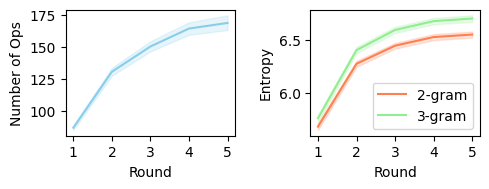

In [27]:
import seaborn as sns

import matplotlib.pyplot as plt

# Assuming df_programs is already defined and contains the 'num_ops' and 'round' columns
fig_diversity, diversity_axes = plt.subplots(1, 2, figsize=(5, 2))

# Number of Operations per Round
sns.lineplot(x='round', y='num_ops', data=df_programs,
             ax=diversity_axes[0], color='skyblue')
diversity_axes[0].set_xlabel('Round')
diversity_axes[0].set_ylabel('Number of Ops')
diversity_axes[0].set_xticks(range(1, df_programs['round'].max() + 1))

# 2-gram and 3-gram Entropy per Round on same plot
sns.lineplot(x='round', y='entropy_2gram', data=df_programs,
             ax=diversity_axes[1], color='coral', label='2-gram')
sns.lineplot(x='round', y='entropy_3gram', data=df_programs,
             ax=diversity_axes[1], color='lightgreen', label='3-gram')
diversity_axes[1].set_xlabel('Round')
diversity_axes[1].set_ylabel('Entropy')
diversity_axes[1].set_xticks(range(1, df_programs['round'].max() + 1))
diversity_axes[1].legend()


plt.tight_layout()
plt.savefig('images/rq_program_diversity_combined.pdf')
plt.show()

# plt.figure(figsize=(5, 3))
# sns.lineplot(x='round', y='entropy_2gram_only_type',
#              data=df_programs, color='coral', label='2-gram')
# sns.lineplot(x='round', y='entropy_3gram_only_type',
#              data=df_programs, color='lightgreen', label='3-gram')
# plt.title('N-gram Entropy (Only Type) per Round')
# plt.xlabel('Round')
# plt.ylabel('Entropy')
# plt.xticks(range(1, df_programs['round'].max() + 1))
# plt.legend()
# plt.savefig('images/rq_program_diversity_entropy_ngram_only_type.pdf')
# plt.show()

## Coverage over time

In [28]:
coverage_data_over_time = []
# coverage_xml_path = Path(
#     EXPERIMENTS_QITE[SELECTED_EXP_QITE]["path"]) / "coverage_xml"

for exp_name in EXPERIMENTS_COVERAGE:
    print(f"\nExperiment: {exp_name}")
    exp_data = EXPERIMENTS_QITE[exp_name]
    coverage_xml_path = Path(exp_data["path"]) / "coverage_xml"

    # Get all numeric subdirectories and sort them
    time_dirs = sorted(
        [d for d in coverage_xml_path.iterdir()
         if d.is_dir() and d.name.isdigit()],
        key=lambda x: int(x.name))

    for time_dir in time_dirs:
        coverage_file = time_dir / "coverage_platforms.json"
        if coverage_file.exists():
            with open(coverage_file, "r") as f:
                coverage_data = json.load(f)
                # Add timestamp information
                metadata = json.load(
                    (time_dir / "_qite_stats.jsonl").open("r"))
                coverage_data["round"] = int(metadata["round"])
                coverage_data["timestamp"] = int(time_dir.name)
                coverage_data['experiment'] = exp_name
                coverage_data_over_time.append(coverage_data)

# Convert to DataFrame for easier analysis
df_coverage = pd.DataFrame(coverage_data_over_time)
print("columns: ", list(df_coverage.columns))


Experiment: 2025_03_08__23_10_1f8161

Experiment: 2025_03_08__23_10_25ac21

Experiment: 2025_03_08__23_10_49eaef

Experiment: 2025_03_08__23_10_387c1b

Experiment: 2025_03_08__23_10_c67442
columns:  ['qiskit', 'pennylane', 'pytket', 'round', 'timestamp', 'experiment']


In [29]:
# for all the columns except time, expand their content and make new records with the same time and each of the cell of the different remaining cols
# Convert nested dictionary structure to a more usable format
data_expanded = []
for _, row in df_coverage.iterrows():
    timestamp = row['timestamp']
    n_round = row["round"]
    exp_name = row["experiment"]
    for platform in PLATFORMS:
        platform_data = row[platform]
        data_expanded.append({
            'timestamp': timestamp,
            'experiment': exp_name,
            'round': n_round,
            'platform': platform,
            'coverage_percentage': platform_data['coverage_percentage'],
            'covered': platform_data['covered'],
            'total': platform_data['total'],
            'covered_lines': platform_data['covered_lines'],
            'total_lines': platform_data['total_lines']
        })


df_coverage_expanded = pd.DataFrame(data_expanded)
# keep only timestamp up to 5 included
df_coverage_expanded = df_coverage_expanded[df_coverage_expanded
                                            ["timestamp"] <= 5]
df_coverage_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            75 non-null     int64  
 1   experiment           75 non-null     object 
 2   round                75 non-null     int64  
 3   platform             75 non-null     object 
 4   coverage_percentage  75 non-null     float64
 5   covered              75 non-null     int64  
 6   total                75 non-null     int64  
 7   covered_lines        75 non-null     object 
 8   total_lines          75 non-null     object 
dtypes: float64(1), int64(4), object(4)
memory usage: 5.4+ KB


In [30]:
df = df_coverage_expanded.copy()
# get a dictioanry with the highest "total" for each platofrm
map_max_total = df.groupby("platform")["total"].max().to_dict()
# replace the total with the max total for each platform
df["total"] = df["platform"].map(map_max_total)

# group by platform and round, merge the lines set and get the list of the rest
df = df.groupby(["experiment", "platform", "round"]).agg({
    'timestamp': 'first',
    'total': 'first',
    'covered_lines': 'sum',
}).reset_index()

# consider subset of platforms, sort them by round and timestamp
# compute the cumulative sum of covered lines (as set)
dfs = []
for platform in PLATFORMS:
    df_platform = df[df["platform"] == platform].sort_values(
        by=["round", "timestamp"])
    df_platform["cumulative_covered_lines"] = df_platform["covered_lines"].cumsum()
    # create set
    df_platform["cumulative_covered_lines"] = df_platform["cumulative_covered_lines"].apply(
        set)
    df_platform['n_covered'] = df_platform['cumulative_covered_lines'].apply(
        len)
    dfs.append(df_platform)

df = pd.concat(dfs)
df["covered_cumulative_percentage"] = df["n_covered"] / df["total"] * 100

df.drop(columns=["covered_lines", "cumulative_covered_lines"], inplace=True)

df

,experiment,platform,round,timestamp,total,n_covered,covered_cumulative_percentage
10,2025_03_08__23_10_1f8161,qiskit,1,1,72751,10077,13.851356
25,2025_03_08__23_10_25ac21,qiskit,1,1,72751,10084,13.860978
40,2025_03_08__23_10_387c1b,qiskit,1,1,72751,10123,13.914585
55,2025_03_08__23_10_49eaef,qiskit,1,1,72751,10143,13.942076
70,2025_03_08__23_10_c67442,qiskit,1,1,72751,10146,13.946200
...,...,...,...,...,...,...,...
9,2025_03_08__23_10_1f8161,pytket,5,5,38416,11697,30.448251
24,2025_03_08__23_10_25ac21,pytket,5,5,38416,11697,30.448251
39,2025_03_08__23_10_387c1b,pytket,5,5,38416,11697,30.448251
54,2025_03_08__23_10_49eaef,pytket,5,5,38416,11704,30.466472


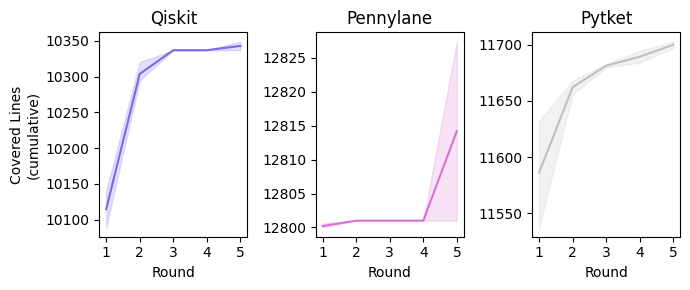

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(7, 3), squeeze=False)

# Create subplot for each platform
for idx, platform in enumerate(PLATFORMS):
    platform_data = df[df['platform'] == platform]

    # Plot covered lines over time
    sns.lineplot(data=platform_data, x='round', y='n_covered',
                 color=PLATFORM_COLORS[platform], ax=axs[0, idx])
    axs[0, idx].set_title(platform.capitalize())
    if idx == 0:  # Only add ylabel for leftmost plots
        axs[0, idx].set_ylabel('Covered Lines\n(cumulative)')
    else:
        axs[0, idx].set_ylabel('')
    axs[0, idx].set_xlabel('Round')

    # # Plot coverage percentage over time
    # sns.lineplot(data=platform_data, x='round',
    #              y='covered_cumulative_percentage',
    #              color=PLATFORM_COLORS[platform],
    #              ax=axs[1, idx])
    # if idx == 0:  # Only add ylabel for leftmost plots
    #     axs[1, idx].set_ylabel('Coverage (%)\n(cumulative)')
    # axs[1, idx].set_xlabel('Round')

    axs[0, idx].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig('images/rq_coverage_over_time.pdf')
plt.show()